# Go

In [1]:
from sklearn import naive_bayes
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

Primero se leerán los datos.

In [2]:
datacsv_ent = pd.read_csv('partidas_entrenamiento.csv')
datanp_ent = datacsv_ent.to_numpy()
X_ent = datanp_ent[:, :-1]
y_ent = datanp_ent[:, -1]
datacsv_pru = pd.read_csv('partidas_prueba.csv')
datanp_pru = datacsv_pru.to_numpy()
X_pru = datanp_pru[:, :-1]
y_pru = datanp_pru[:, -1]

## Clasificador bayesiano ingenuo

Se entrenará un clasificador bayesiano ingenuo para predecir las partidas de Go. Se asumirá distribución categórica. Se va a evaluar este clasificador con el conjunto de prueba.

In [3]:
## Calcula los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
# de un clasificador, dado un conjunto de prueba.
def evaluacion(clasificador, X_test, y_test):
    vp = 0
    vn = 0
    fp = 0
    fn = 0
    prediccion = clasificador.predict(X_test)
    for i in range(y_test.shape[0]):
        if y_test[i] == 1 and prediccion[i] == 1:
            vp += 1
        elif y_test[i] == 0 and prediccion[i] == 0:
            vn += 1
        elif y_test[i] == 1 and prediccion[i] == 0:
            fn += 1
        else: # y_test[i] == 0 and prediccion[i] == 1
            fp += 1
    return (vp, vn, fp, fn)

In [4]:
nbc_cat = naive_bayes.CategoricalNB()
nbc_cat.fit(X_ent, y_ent)
vp_nbc, vn_nbc, fp_nbc, fn_nbc = evaluacion(nbc_cat, X_pru, y_pru)
precision_nbc = vp_nbc / (vp_nbc + fp_nbc)
exhaustividad_nbc = vp_nbc / (fn_nbc + vp_nbc)
tasafp_nbc = fp_nbc / (vn_nbc + fp_nbc)
print('Precisión:', precision_nbc)
print('Exhaustividad:', exhaustividad_nbc)
print('Tasa de falsos positivos:', tasafp_nbc)

Precisión: 0.7764705882352941
Exhaustividad: 0.8048780487804879
Tasa de falsos positivos: 0.5757575757575758


Se generarán 10 nuevas partidas, dado el clasificador entrenado.

In [5]:
## Función para generar partidas aleatorias
# @param cbi: clasificador bayesiano ingenuo previamente entrenado
# @param num_matches: número de partidas
# @param maximo_id: id máximo de los jugadores
def genera_partidas(cbi, num_matches, maximo_id):
    lista_partidas = []
    for i in range(num_matches):
        partida = []
        j1 = random.randint(1, maximo_id)
        j2 = random.randint(1, maximo_id)
        partida.append(j1)
        partida.append(j2)
        lista_partidas.append(partida)
    xpg = np.array(lista_partidas)
    ypg = cbi.predict(xpg)
    return (xpg, ypg)

X_gen, y_gen = genera_partidas(nbc_cat, 10, X_ent.max()-1)
partidas_nuevas = np.concatenate([X_gen, y_gen[:,np.newaxis]], axis = 1)
print('Partidas generadas:')
print(partidas_nuevas)

Partidas generadas:
[[110  27   0]
 [ 65   2   0]
 [109  41   0]
 [129  80   0]
 [112   7   1]
 [ 50  35   0]
 [118 109   0]
 [ 75  25   1]
 [ 16  51   0]
 [ 14  35   0]]


En este punto, se le concatenará una columna de 1's a todas las X's.

In [6]:
def concat1(mat):
    unos = np.ones((mat.shape[0], 1))
    return np.concatenate([unos, mat], axis = 1)

X_ent = concat1(X_ent)
X_pru = concat1(X_pru)
X_gen = concat1(X_gen)

## Regresión logística
Se definirá una clase de regresión logística. Asume que los vectores de entrada tienen un 1 pegado a la izquierda.

In [7]:
## Definición de función sigmoide
def sigm(z):
    den = 1 + math.exp(-z)
    return 1/den

In [8]:
class RegresionLogistica():
    def __init__(self, alfa = 3e-4, max_iter = 100000, tol = 1e-4):
        self.alfa = alfa
        self.max_iter = max_iter
        self.theta = np.zeros(1)
        self.tol = tol
    
    # Calcula el vector q
    def calcula_q(self, Xp):
        v1 = np.zeros(Xp.shape[0])
        for i in range(Xp.shape[0]):
            v1[i] = np.dot(self.theta, Xp[i])
        return np.array(list(map(sigm, v1)))
    
    # Inicializa el vector theta con valores aleatorios
    def ini_theta(self, d):
        self.theta = np.random.rand(d)
    
    # Cálculo del vector gradiente
    def gradiente(self, X, q, y):
        return X.T @ (q - y)
    
    def tolerancia(self, theta1, theta2):
        max_tol = -1
        for i in range(theta1.shape[0]):
            delta = math.fabs(theta1[i] - theta2[i])
            if delta > max_tol:
                max_tol = delta
        return max_tol
    
    # Algoritmo de descenso por gradiente
    def descenso(self, X, y):
        self.ini_theta(X.shape[1])
        for it in range(self.max_iter):
            q = self.calcula_q(X)
            theta2 = self.theta - self.alfa*self.gradiente(X, q, y)
            if self.tolerancia(self.theta, theta2) < self.tol:
                break
            else:
                self.theta = theta2
    
    # Entrenamiento
    def fit(self, X, y):
        self.descenso(X, y)
    
    # devuelve las probabilidades, dadas las thetas y las x
    def predict_proba(self, X):
        return self.calcula_q(X)
    
    # devuelve una predicción
    def predict(self, X):
        probas = self.predict_proba(X)
        prediccion = np.zeros(shape = probas.shape, dtype = np.int32)
        for i in range(probas.shape[0]):
            if probas[i] > 0.5:
                prediccion[i] = 1
        return prediccion

Antes de hacer la regresión, se realizará un reescalado de los datos, y así todos los datos estarán entre 0 y 1.

In [9]:
def reescalado(X):
    X_ree = np.ones(X.shape)
    for c in range(1, X.shape[1]):
        columna = X[:,c]
        xmax = columna.max()
        xmin = columna.min()
        for f in range(X.shape[0]):
            X_ree[f][c] = (X[f][c] - xmin)/(xmax - xmin)
    return X_ree

X_ent_re = reescalado(X_ent)
X_pru_re = reescalado(X_pru)
X_gen_re = reescalado(X_gen)

Se entrena el modelo y visualizamos los parámetros (las $\theta$'s).

In [10]:
rlog = RegresionLogistica()
rlog.fit(X_ent_re, y_ent)
print(rlog.theta)

[ 0.22775439  0.45199369 -0.72859031]


Los números observados son las thetas: $[\theta_0, \theta_1, \theta_2]$ para el modelo de regresión logística:
$$ P(y=1|x) = \frac{1}{1+exp(-(\theta_0 + \theta_1 x_1 + \theta_2 x_2))}$$

## Curvas

Ahora se graficarán las curvas ROC y de precisión-exhaustividad.

In [11]:
def roc(probabilities, y):
    # obtenemos los indices de las predicciones ordenadas de menor a mayor probabilidad
    orden = np.argsort(probabilities)[::-1]
    # ordenamos predicciones y valores reales
    porden = probabilities[orden]
    yorden = y[orden]
    # Nos quedamos únicamente con los índices repetidos
    idxs = np.unique(porden, return_index = True)[1][::-1]
    rvps = yorden[idxs].cumsum()
    rfps = 1.0 + idxs - rvps 
    n_pos = y.sum()
    n_neg = y.shape[0] - n_pos

    return rvps / n_pos, rfps / n_neg

Podemos calcular el área bajo la curva ROC usando usando la fórmula de shoelace.

In [12]:
def area_poligono(vertices):
    area = 0.0
    n_vert = len(vertices)
    for i in range(n_vert - 1):
        area = area + vertices[i][0] * vertices[i + 1][1]
        area = area - vertices[i + 1][0] * vertices[i][1]
    area = area + vertices[n_vert - 1][0] * vertices[0][1]
    area = area - vertices[0][0] * vertices[n_vert - 1][1]
    return 0.5 * abs(area)

def compute_aucroc(tfp, tvp):
    auc = 0.0
    fprev = 0.0
    vprev = 0.0
    for i,(f,v) in enumerate(zip(tfp, tvp)):
        auc += area_poligono([[fprev, 0], [fprev, vprev], [f, v], [f, 0]])
        fprev = f
        vprev = v
    return auc

Evaluamos el modelo de regresión logística (<tt>rlog</tt>).

In [13]:
vp_rlog, vn_rlog, fp_rlog, fn_rlog = evaluacion(rlog, X_pru_re, y_pru)
precision_rlog = vp_rlog / (vp_rlog + fp_rlog)
exhaustividad_rlog = vp_rlog / (fn_rlog + vp_rlog)
tasafp_rlog = fp_rlog / (vn_rlog + fp_rlog)
print('Precisión:', precision_rlog)
print('Exhaustividad:', exhaustividad_rlog)
print('Tasa de falsos positivos:', tasafp_rlog)

Precisión: 0.7368421052631579
Exhaustividad: 0.8536585365853658
Tasa de falsos positivos: 0.7575757575757576


### Curva ROC

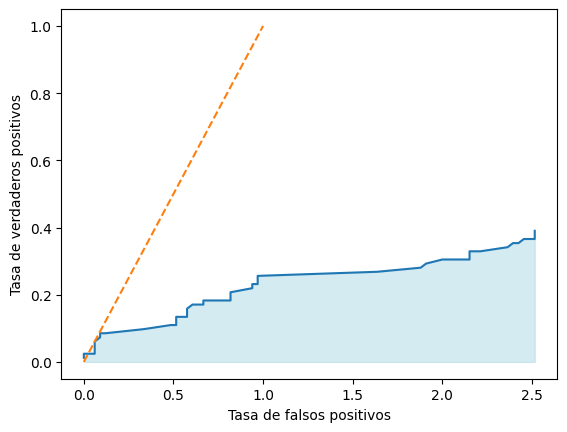

Área bajo la curva: 0.5770509977827052


In [14]:
probas_rlog = rlog.predict_proba(X_pru_re)
rvps, rfps = roc(probas_rlog, y_pru)
plt.plot(rfps, rvps)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(rfps, rvps, 0, alpha=0.5, color = 'lightblue')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.show()
aucroc = compute_aucroc(rfps, rvps)
print('Área bajo la curva:', aucroc)

### Curva de precisión-exhaustividad

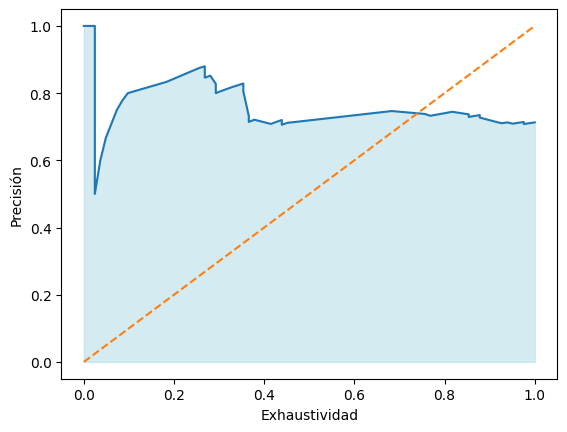

Área bajo la curva: 0.7588614364932231


In [15]:
ps, rs, _ = precision_recall_curve(y_pru, probas_rlog)
plt.plot(rs, ps)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(rs, ps, 0, alpha=0.5, color = 'lightblue')
plt.xlabel('Exhaustividad')
plt.ylabel('Precisión')
plt.show()
aucpe = auc(rs, ps)
print('Área bajo la curva:', aucpe)

## Diferencias entre clasificador bayesiano ingenuo y regresión logística

- ¿Qué ventajas y desventajas tienen los modelos entrenados?

<b>Ventajas del CBI:</b> Tienen solución cerrada, hay diferentes tipos de distribuciones, funcionan mejor con números enteros.

<b>Desventajas del CBI:</b> Es necesario saber qué distribución usar, supone independencia de las variables de entrada.

<b>Ventajas de regresión logística:</b> No es necesario hacer suposiciones sobre las variables de entrada, funciona para cualquier valor numérico.

<b>Desventajas de regresión logística:</b> No tienen solución cerrada, los valores de las características pueden estar en rangos de valores muy diferentes (lo cual puede afectar la convergencia), se puede sobreajustar a los valores de entrenamiento.

- ¿Qué pasaría si se entrena el clasificador bayesiano ingenuo con los vectores recodificados o si se entrena un modelo de regresión logística usando los vectores de entrada originales?

<b>Entrenar cbi con valores recodificados:</b> Dado que se eligió una distribución categórica, no es posible entrenar el clasificador bayesiano con los valores recodificados (que van de 0 a 1). Habría sido necesario elegir otro tipo de distribución (gausiana, por ejemplo).

<b>Entrenar rl con valores no codificados:</b> En la regresión logística se tiene el término $exp(-\theta^{\top} x)$. Si los valores de $x$ son muy grandes, entonces $\theta^{\top} x$ será muy grande, lo que hará que $exp(-\theta^{\top} x)$ se redondee a 0 (por la precisión de las computadoras) y entonces no convergerá.

- ¿Consideras que las presuposiciones de cada clasificador son apropiadas para los datos del problema?

Sí

- ¿Para este tipo de problemas cuál de los dos recomendarías y por qué?

Recomendaría el clasificador bayesiano ingenuo, pues los valores de entrada son números enteros que van de 1 a $j$, donde $j$ es el número máximo de jugadores.